In [1]:
# Install the local package in development mode
import subprocess
import sys
import os

# Explicitly set the path to the redfield_education directory
project_dir = r"c:\Users\leopo\.vscode\redfield_education"
print(f"Installing package from: {project_dir}")

# Install in editable mode
result = subprocess.run([sys.executable, "-m", "pip", "install", "-e", project_dir], 
                       capture_output=True, text=True)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)
print("Return code:", result.returncode)

Installing package from: c:\Users\leopo\.vscode\redfield_education


STDOUT: Obtaining file:///C:/Users/leopo/.vscode/redfield_education
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for redfield-education (pyproject.toml): started
  Building editable for redfield-education (pyproject.toml): finished with status 'done'
  Created wheel for redfield-education: filename=redfield_education-1.0-0.editable-py3-none-any.whl size=2457 sha256=fa1959933f4ce8b79c36c6c7c506f3612d01b7035ac5c5256fd968c1c287cadb
  Stored in directory: C:\Users\leopo\AppData\Local\Temp\pip-ephem-wheel-cache-ajrj1tkn\wheels\8

In [2]:
# Add src directory to Python path
import sys
import os

# Add the src directory to Python path
src_path = r"c:\Users\leopo\.vscode\redfield_education\src"
if src_path not in sys.path:
    sys.path.insert(0, src_path)
    
print(f"Added to Python path: {src_path}")
print("Current Python path:")
for i, path in enumerate(sys.path[:5]):  # Show first 5 paths
    print(f"  {i}: {path}")

# Test if we can now import the modules
try:
    import diagnostics
    import plotting
    print("✓ Successfully imported diagnostics and plotting modules!")
except ImportError as e:
    print(f"✗ Import failed: {e}")

Added to Python path: c:\Users\leopo\.vscode\redfield_education\src
Current Python path:
  0: c:\Users\leopo\.vscode\redfield_education\src
  1: c:\Users\leopo\anaconda3\envs\redfield\python313.zip
  2: c:\Users\leopo\anaconda3\envs\redfield\DLLs
  3: c:\Users\leopo\anaconda3\envs\redfield\Lib
  4: c:\Users\leopo\anaconda3\envs\redfield
✓ Successfully imported diagnostics and plotting modules!


# Qubit Pure Dephasing: Bloch-Redfield vs Lindblad
We study a qubit with Hamiltonian $H = \frac{mega_0}{2} igma_z$ coupled to a bosonic bath inducing pure dephasing.
We compare QuTiP's `brmesolve` (full Redfield) and `mesolve` with a Lindblad dephasing operator. We monitor density matrix eigenvalues to detect CP violations (if any).

c:\Users\leopo\anaconda3\envs\redfield\Lib\site-packages\qutip\core\environment.py:1647: UserWarning: The mpmath module is required for some operations on Ohmic environments, but it is not installed.
  warnings.warn(


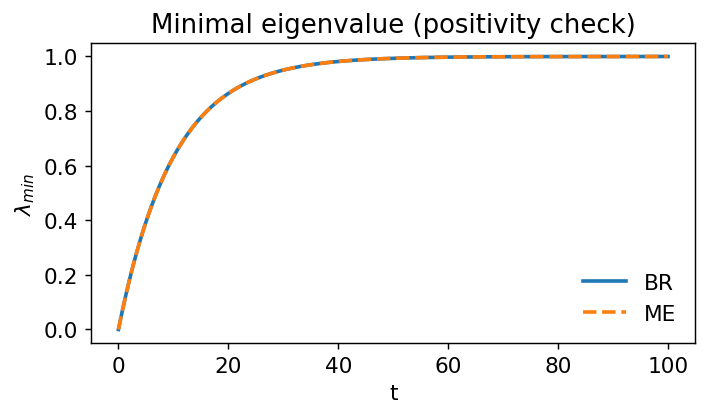

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmaz, sigmax, Qobj, brmesolve, mesolve, BosonicEnvironment, tensor
from qutip import OhmicEnvironment
from diagnostics import density_matrix_positivity, trajectory_min_eigs
from plotting import style, plot_min_eig, populations_from_states
style()
w0 = 1.0  # qubit splitting
H = 0.5 * w0 * sigmaz()
# pure dephasing coupling operator A = sigma_z (commutes with H)
A = sigmaz()

# Ohmic bath providing S(0) > 0 giving dephasing rate.
bath = OhmicEnvironment(T=0.5, wc=10.0, alpha=0.05, s=1.0)
psi0 = basis(2,1)+basis(2,0)
tlist = np.linspace(0,100,300)
# Bloch-Redfield evolution
res_br = brmesolve(H=H, psi0=psi0, tlist=tlist, a_ops=[[A, bath]], e_ops=[])
# Lindblad model with rate gamma_phi = S(0)
gamma_phi = bath.power_spectrum(0)
res_me = mesolve(H=H, rho0=psi0, tlist=tlist, c_ops=[np.sqrt(gamma_phi)*A], e_ops=[])
min_eigs_br = trajectory_min_eigs(res_br.states)
min_eigs_me = trajectory_min_eigs(res_me.states)
plt.figure(figsize=(6,3))
plt.plot(tlist, min_eigs_br, label='BR')
plt.plot(tlist, min_eigs_me, label='ME', ls='--')
plt.ylabel(r'$\lambda_{min}$')
plt.xlabel('t')
plt.legend(frameon=False)
plt.title('Minimal eigenvalue (positivity check)')
plt.show()

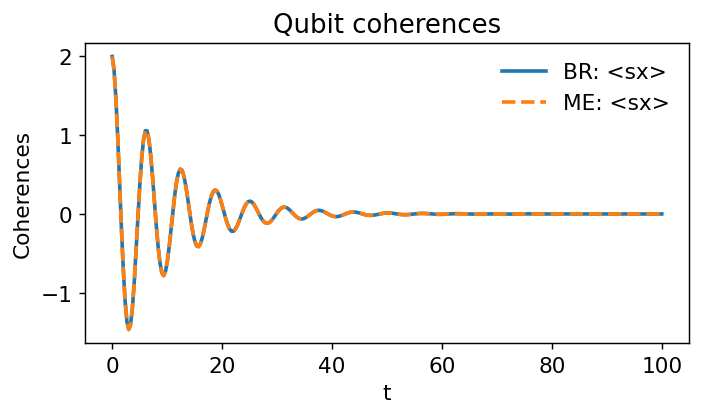

In [4]:
from qutip import sigmax, expect
def coherences_from_states(states):
    """Return coherences array shape (dim, n_times)."""
    cohs = expect(sigmax(), states)
    return cohs

cohs_br = coherences_from_states(res_br.states)
cohs_me = coherences_from_states(res_me.states)


plt.figure(figsize=(6,3))
plt.plot(tlist, cohs_br, label='BR: <sx>')
plt.plot(tlist, cohs_me, label='ME: <sx>', ls='--')
plt.ylabel('Coherences')
plt.xlabel('t')
plt.legend(frameon=False)
plt.title('Qubit coherences')
plt.show()